<a href="https://colab.research.google.com/github/kavyajeetbora/ML_algorithms/blob/master/MLOPs/02_deploying_simple_classification_model_with_fastapi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Set up the Environment

In [1]:
!pip install -q pyngrok fastapi uvicorn python-dotenv nest-asyncio streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 35.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 52.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 4.2 MB/s eta 0:00:00


In [2]:
from dotenv import load_dotenv
from fastapi import FastAPI
from fastapi.responses import HTMLResponse, JSONResponse
import nest_asyncio
import uvicorn
from pyngrok import ngrok
import os
import pickle
import matplotlib.pyplot as plt
import numpy as np

In [3]:
if os.path.exists(".env"):
    os.remove(".env")

from google.colab import files
uploaded = files.upload()
if uploaded:
    if load_dotenv(".env"):
        print("Uploaded and Loaded Sucessfully")

Saving .env to .env
Uploaded and Loaded Sucessfully


## Machine Learning Pipeline

In [4]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

In [5]:
# Create a synthetic classification dataset
X, y = make_classification(n_samples=1000, n_features=20, random_state=42)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train a Logistic Regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

**Note**: By default, the logistic regression model assumes greater than or equal to 0.5 as threshold.

Alternatively we can predict the probabilities and set the threshold manually as well:

In [6]:
y_probs = model.predict_proba(X_test)

print("Probabilities for ")
y_probs[:,1][:10]

Probabilities for 


array([0.64888799, 0.86790467, 0.47540675, 0.85263523, 0.95549976,
       0.05427555, 0.21776584, 0.82185232, 0.74542641, 0.38957666])

### Evaluation

In [7]:
def evaluate_model(y_test, y_pred):
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")

evaluate_model(y_test, y_pred)

Accuracy: 0.855
Precision: 0.9148936170212766
Recall: 0.8037383177570093
F1 Score: 0.8557213930348259


### Choosing Thresold

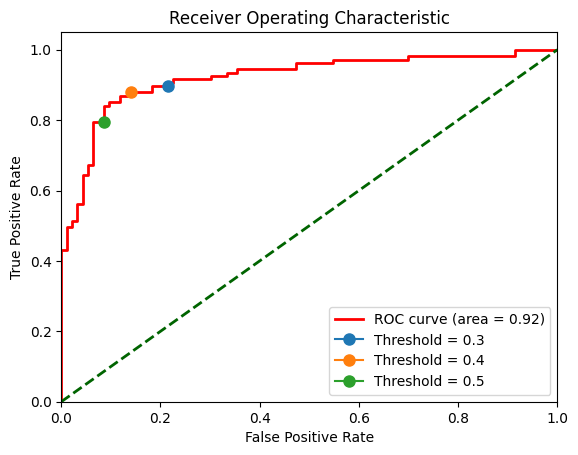

In [17]:
# Plot the ROC curve
y_prob = model.predict_proba(X_test)[:, 1]  # Probability of positive class
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='red', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='darkgreen', lw=2, linestyle='--')

# Plot points for specific thresholds
specific_thresholds = [0.3, 0.4, 0.5]
for threshold in specific_thresholds:
    idx = np.argmin(np.abs(thresholds - threshold)) #find closest threshold index
    plt.plot(fpr[idx], tpr[idx], marker='o', markersize=8, label=f'Threshold = {threshold}')


plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## Evaluate different thresholds

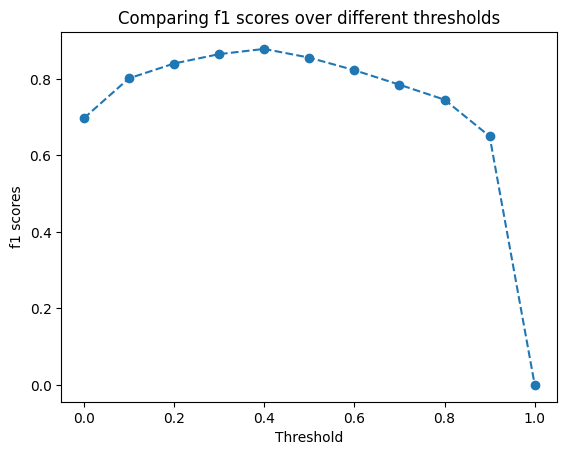

In [9]:
# Evaluate metrics at different thresholds
y_prob = y_probs[:,1]

thresholds = np.arange(0.0, 1.1, 0.1)
f1_scores = []

for threshold in thresholds:
    y_pred_custom = (y_prob >= threshold).astype(int)
    f1 = f1_score(y_test, y_pred_custom)
    f1_scores.append(f1)

plt.plot(thresholds, f1_scores, linestyle="--", marker="o")
plt.xlabel("Threshold")
plt.ylabel("f1 scores")
plt.title("Comparing f1 scores over different thresholds")
plt.show()

So as per this plot we can conclude that `0.4` is the threshold we are getting maximum `f1` score.

In [10]:
def make_prediction(X, model, threshold):
    prob = model.predict_proba(X)[:,1]
    prediction = [1 if p>=threshold else 0 for p in prob]
    return prediction

In [11]:
predictions = make_prediction(X_test, model, 0.4)
evaluate_model(predictions, y_test)

Accuracy: 0.87
Precision: 0.8785046728971962
Recall: 0.8785046728971962
F1 Score: 0.8785046728971962


## Create the application using `FastAPI`

In [12]:
app = FastAPI()

@app.get("/", response_class=HTMLResponse)
async def read_root():
    html_content = """
    <html>
        <head>
            <title>Machine Learning Classification</title>
        </head>
        <body>
            <h1>Welcome to Classification</h1>
            <p>This is page for machine learning classification.</p>
        </body>
    </html>
    """
    return HTMLResponse(content=html_content)


@app.get("/predict", response_class=JSONResponse)
async def predict_inputs():

    ## We are using generated inputs for simplicity
    generated_inputs = np.random.randn(1,20)

    ## make predictions
    prediction = make_prediction(generated_inputs, model, 0.4)[0]
    response = "positive" if prediction == 1 else "negative"
    data = {"input_data": generated_inputs.tolist(),'response': response}
    return JSONResponse(content=data)

## Deploy the application to a public url

In [13]:
# Set up the FastAPI app to run on a public URL via ngrok
port = 8004
ngrok_tunnel = ngrok.connect(port)
print(f"Public URL: {ngrok_tunnel.public_url}")

nest_asyncio.apply()
uvicorn.run(app, port=port)

Public URL: https://58e7-104-196-36-122.ngrok-free.app


INFO:     Started server process [260]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8004 (Press CTRL+C to quit)
INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [260]
